# Milestone 4: Reinforcement Learning Trading Agent

This notebook demonstrates the RL-based trading system with regime-conditioned state space.

**Key components:**
1. Gymnasium-compatible trading environment
2. PPO agent with regime features in state
3. Walk-forward validation framework
4. Performance analysis vs. buy & hold baseline

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
plt.style.use('seaborn-v0_8-whitegrid')

print("Imports complete!")

Imports complete!


## 1. Load and Prepare Data

We'll combine price features, macro indicators, and regime labels into a unified state space.

In [2]:
from data.data_pipeline import DataPipeline
from regime.hmm_detector import HMMRegimeDetector
from regime.rule_based_detector import RuleBasedRegimeDetector

# Initialize pipeline
pipeline = DataPipeline()

# Load aligned data
print("Loading aligned price and macro data...")
df = pipeline.load_aligned_data(
    symbol='SPY',
    start_date='2020-01-01',
    end_date='2024-01-01'
)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns: {df.columns.tolist()[:10]}...")

Loading aligned price and macro data...
Data shape: (1462, 48)
Date range: 2020-01-01 00:00:00 to 2024-01-01 00:00:00

Columns: ['price_Open', 'price_High', 'price_Low', 'price_Close', 'price_Adj_Close', 'price_Volume', 'price_Dividends', 'price_Stock_Splits', 'price_Capital_Gains', 'price_return_1d']...


In [3]:
# Add regime labels using rule-based detector
print("\nDetecting market regimes...")

# Prepare macro data for regime detection
macro_cols = ['macro_VIXCLS', 'macro_T10Y2Y', 'macro_BAA10Y', 'macro_UNRATE']
available_macro = [c for c in macro_cols if c in df.columns]

if len(available_macro) >= 2:
    # Rename for detector
    macro_df = df[available_macro].copy()
    macro_df.columns = [c.replace('macro_', '') for c in macro_df.columns]
    
    # Use rule-based detector (more interpretable)
    detector = RuleBasedRegimeDetector()
    df['regime'] = detector.predict(macro_df)
    
    # Convert to numeric for one-hot encoding
    regime_map = {'Expansion': 0, 'Contraction': 1, 'Crisis': 2}
    df['regime_numeric'] = df['regime'].map(regime_map)
    
    print(f"\nRegime distribution:")
    print(df['regime'].value_counts())
else:
    print("Insufficient macro columns for regime detection")
    df['regime'] = 'Unknown'
    df['regime_numeric'] = 0


Detecting market regimes...

Regime distribution:
regime
Contraction    862
Expansion      487
Crisis         113
Name: count, dtype: int64


In [4]:
# Select features for RL state space
# Include price features, macro features, but not the target

# Price-based features (using actual column names from pipeline)
price_features = [
    'price_return_1d', 'price_return_5d', 'price_return_21d',
    'price_volatility_21d', 'price_volatility_63d',
    'price_rsi_14', 'price_close_to_sma50', 'price_close_to_sma200'
]

# Macro features
macro_features = [
    'macro_VIXCLS', 'macro_T10Y2Y', 'macro_VIX_percentile'
]

# Filter to available columns
all_features = price_features + macro_features
feature_columns = [c for c in all_features if c in df.columns]

print(f"Selected {len(feature_columns)} features for state space:")
for f in feature_columns:
    print(f"  - {f}")

# Drop rows with NaN in features
df_clean = df.dropna(subset=feature_columns + ['regime_numeric', 'price_Close'])
print(f"\nClean data shape: {df_clean.shape}")

Selected 11 features for state space:
  - price_return_1d
  - price_return_5d
  - price_return_21d
  - price_volatility_21d
  - price_volatility_63d
  - price_rsi_14
  - price_close_to_sma50
  - price_close_to_sma200
  - macro_VIXCLS
  - macro_T10Y2Y
  - macro_VIX_percentile

Clean data shape: (807, 50)


## 2. Trading Environment Overview

Our custom `TradingEnv` is compatible with Gymnasium and Stable-Baselines3.

In [5]:
from rl.trading_env import TradingEnv

# Create environment
env = TradingEnv(
    df=df_clean,
    feature_columns=feature_columns,
    price_column='price_Close',
    regime_column='regime_numeric',
    n_regimes=3,
    initial_balance=100000.0,
    transaction_cost=0.001,  # 0.1% per trade
)

print("Environment Configuration:")
print(f"  Action space: {env.action_space} (0=Sell, 1=Hold, 2=Buy)")
print(f"  Observation space: {env.observation_space.shape}")
print(f"  State dimension breakdown:")
print(f"    - Features: {len(feature_columns)}")
print(f"    - Regime one-hot: 3")
print(f"    - Portfolio state: 2 (position, unrealized P&L)")
print(f"  Initial balance: ${env.initial_balance:,.0f}")
print(f"  Transaction cost: {env.transaction_cost*100}%")

Environment Configuration:
  Action space: Discrete(3) (0=Sell, 1=Hold, 2=Buy)
  Observation space: (16,)
  State dimension breakdown:
    - Features: 11
    - Regime one-hot: 3
    - Portfolio state: 2 (position, unrealized P&L)
  Initial balance: $100,000
  Transaction cost: 0.1%


In [6]:
# Test environment with random actions
print("\nTesting environment with random actions...")

obs, info = env.reset()
print(f"Initial observation shape: {obs.shape}")
print(f"Initial info: {info}")

# Run a few steps
total_reward = 0
for i in range(10):
    action = env.action_space.sample()
    action_name = ['Sell', 'Hold', 'Buy'][action]
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    
    if i < 3:  # Show first 3 steps
        print(f"\nStep {i+1}: Action={action_name}")
        print(f"  Reward: {reward:.4f}")
        print(f"  Position: {info['position']:.2f}")
        print(f"  Portfolio: ${info['portfolio_value']:,.2f}")

print(f"\n...")
print(f"\nAfter 10 random steps:")
print(f"  Total reward: {total_reward:.4f}")
print(f"  Final portfolio: ${info['portfolio_value']:,.2f}")


Testing environment with random actions...
Initial observation shape: (16,)
Initial info: {'step': 1, 'date': '2020-10-16 00:00:00', 'price': np.float64(347.2900085449219), 'position': 0.0, 'portfolio_value': 100000.0, 'balance': 100000.0, 'num_trades': 0, 'regime': np.int64(1)}

Step 1: Action=Hold
  Reward: 0.0000
  Position: 0.00
  Portfolio: $100,000.00

Step 2: Action=Sell
  Reward: -1.3574
  Position: -1.00
  Portfolio: $-550.57

Step 3: Action=Buy
  Reward: 0.0000
  Position: 1.00
  Portfolio: $-550.57

...

After 10 random steps:
  Total reward: -1.3574
  Final portfolio: $-550.57


## 3. Train PPO Agent

We use PPO (Proximal Policy Optimization) for training - it's the most stable algorithm for continuous observation spaces.

In [7]:
from rl.ppo_trader import PPOTrader

# Split data: 70% train, 30% test
train_size = int(len(df_clean) * 0.7)
train_df = df_clean.iloc[:train_size].copy()
test_df = df_clean.iloc[train_size:].copy()

print(f"Train period: {train_df.index.min().date()} to {train_df.index.max().date()} ({len(train_df)} days)")
print(f"Test period:  {test_df.index.min().date()} to {test_df.index.max().date()} ({len(test_df)} days)")

Train period: 2020-10-15 to 2023-01-11 (564 days)
Test period:  2023-01-12 to 2023-12-29 (243 days)


In [8]:
# Create and train PPO trader
print("\nInitializing PPO Trader...")

trader = PPOTrader(
    df=train_df,
    feature_columns=feature_columns,
    regime_column='regime_numeric',
    n_regimes=3,
    price_column='price_Close',
    initial_balance=100000.0,
    transaction_cost=0.001,
    seed=42,
    device='cpu',  # Use CPU for stability
    verbose=1
)

print(f"\nPPO Hyperparameters:")
for key, value in trader.ppo_params.items():
    print(f"  {key}: {value}")


Initializing PPO Trader...
Using cpu device



PPO Hyperparameters:
  learning_rate: 0.0003
  n_steps: 2048
  batch_size: 64
  n_epochs: 10
  gamma: 0.99
  gae_lambda: 0.95
  clip_range: 0.2
  ent_coef: 0.01
  vf_coef: 0.5
  max_grad_norm: 0.5


In [9]:
# Train the agent
print("\n" + "="*60)
print("TRAINING PPO AGENT")
print("="*60)

# Note: For demonstration, we use fewer timesteps. Production would use 500k+
TIMESTEPS = 50000  # Reduced for notebook execution speed

train_stats = trader.train(
    total_timesteps=TIMESTEPS,
    progress_bar=False  # Disabled for batch execution
)

print(f"\nTraining complete!")
print(f"  Total timesteps: {train_stats['total_timesteps']}")
print(f"  Episodes completed: {train_stats['episodes']}")


TRAINING PPO AGENT
Training PPO for 50000 timesteps...
Episode 10: Mean Reward (last 10) = 5.38
Episode 20: Mean Reward (last 10) = 311.82
Episode 30: Mean Reward (last 10) = 16.57
Episode 40: Mean Reward (last 10) = 23.67


Episode 50: Mean Reward (last 10) = 37.91
Episode 60: Mean Reward (last 10) = 11.89
Episode 70: Mean Reward (last 10) = 9.19
Episode 80: Mean Reward (last 10) = 5.46
Episode 90: Mean Reward (last 10) = 8.60
Episode 100: Mean Reward (last 10) = 91.31


Episode 110: Mean Reward (last 10) = 14.51
Episode 120: Mean Reward (last 10) = 62.22
Episode 130: Mean Reward (last 10) = -2.22
Episode 140: Mean Reward (last 10) = -8.40
Episode 150: Mean Reward (last 10) = 14.59
Episode 160: Mean Reward (last 10) = 7.84


Episode 170: Mean Reward (last 10) = 6.21
Episode 180: Mean Reward (last 10) = 6.71
Episode 190: Mean Reward (last 10) = 9.33
Episode 200: Mean Reward (last 10) = 11.00
Episode 210: Mean Reward (last 10) = 12.08
Episode 220: Mean Reward (last 10) = 59.10


Episode 230: Mean Reward (last 10) = 7.24
Episode 240: Mean Reward (last 10) = -3.73
Episode 250: Mean Reward (last 10) = 12.66
Episode 260: Mean Reward (last 10) = 124.42
Episode 270: Mean Reward (last 10) = 11.11
Episode 280: Mean Reward (last 10) = -2.63


Episode 290: Mean Reward (last 10) = 148.31
Episode 300: Mean Reward (last 10) = 65.20
Episode 310: Mean Reward (last 10) = 39.51


Episode 320: Mean Reward (last 10) = 167.70
Episode 330: Mean Reward (last 10) = 189.18
Episode 340: Mean Reward (last 10) = 7.92
Episode 350: Mean Reward (last 10) = 12.08
Episode 360: Mean Reward (last 10) = 91.07
Episode 370: Mean Reward (last 10) = 15.14


Episode 380: Mean Reward (last 10) = 22.18
Episode 390: Mean Reward (last 10) = 306.42
Episode 400: Mean Reward (last 10) = 25.49
Episode 410: Mean Reward (last 10) = 7.29
Episode 420: Mean Reward (last 10) = 31.41
Episode 430: Mean Reward (last 10) = 161.00


Episode 440: Mean Reward (last 10) = 54.92
Episode 450: Mean Reward (last 10) = 34.60
Episode 460: Mean Reward (last 10) = 19.38
Episode 470: Mean Reward (last 10) = 36.06
Episode 480: Mean Reward (last 10) = -1.12
Episode 490: Mean Reward (last 10) = 29.00


Episode 500: Mean Reward (last 10) = 32.81
Episode 510: Mean Reward (last 10) = 11.34
Episode 520: Mean Reward (last 10) = 27.11
Episode 530: Mean Reward (last 10) = 26.15
Episode 540: Mean Reward (last 10) = 30.90


Episode 550: Mean Reward (last 10) = 8.44
Episode 560: Mean Reward (last 10) = 62.02
Episode 570: Mean Reward (last 10) = -1.91
Episode 580: Mean Reward (last 10) = 259.33
Episode 590: Mean Reward (last 10) = 11.88
Episode 600: Mean Reward (last 10) = 16.57


Episode 610: Mean Reward (last 10) = 3.89
Episode 620: Mean Reward (last 10) = 44.36
Episode 630: Mean Reward (last 10) = 18.25


Episode 640: Mean Reward (last 10) = 57.49
Episode 650: Mean Reward (last 10) = 41.51
Episode 660: Mean Reward (last 10) = 38.61
Episode 670: Mean Reward (last 10) = 329.85
Episode 680: Mean Reward (last 10) = 204.53
Episode 690: Mean Reward (last 10) = 35.27


Episode 700: Mean Reward (last 10) = 313.14
Episode 710: Mean Reward (last 10) = 184.09
Episode 720: Mean Reward (last 10) = 117.30
Episode 730: Mean Reward (last 10) = 293.80
Episode 740: Mean Reward (last 10) = 26.13
Episode 750: Mean Reward (last 10) = 156.34


Episode 760: Mean Reward (last 10) = 41.62
Episode 770: Mean Reward (last 10) = 344.74
Episode 780: Mean Reward (last 10) = 225.21
Episode 790: Mean Reward (last 10) = 27.65
Episode 800: Mean Reward (last 10) = 41.84
Episode 810: Mean Reward (last 10) = 163.56


Episode 820: Mean Reward (last 10) = 175.00
Episode 830: Mean Reward (last 10) = 78.51
Episode 840: Mean Reward (last 10) = 43.16
Episode 850: Mean Reward (last 10) = 134.04
Episode 860: Mean Reward (last 10) = 513.31


Episode 870: Mean Reward (last 10) = 319.94
Episode 880: Mean Reward (last 10) = 143.88
Episode 890: Mean Reward (last 10) = 173.70
Episode 900: Mean Reward (last 10) = 50.94
Episode 910: Mean Reward (last 10) = 52.94


Episode 920: Mean Reward (last 10) = 374.57
Episode 930: Mean Reward (last 10) = 367.19
Episode 940: Mean Reward (last 10) = 47.02


Episode 950: Mean Reward (last 10) = 48.35
Episode 960: Mean Reward (last 10) = 116.28
Episode 970: Mean Reward (last 10) = 220.65
Episode 980: Mean Reward (last 10) = 213.57
Episode 990: Mean Reward (last 10) = 178.16


Episode 1000: Mean Reward (last 10) = 13.10
Episode 1010: Mean Reward (last 10) = 326.26
Episode 1020: Mean Reward (last 10) = 488.25
Episode 1030: Mean Reward (last 10) = 177.89
Episode 1040: Mean Reward (last 10) = 289.78


Episode 1050: Mean Reward (last 10) = 108.93
Episode 1060: Mean Reward (last 10) = 73.49
Episode 1070: Mean Reward (last 10) = 316.80
Episode 1080: Mean Reward (last 10) = 228.58
Episode 1090: Mean Reward (last 10) = 195.15


Episode 1100: Mean Reward (last 10) = 29.82
Episode 1110: Mean Reward (last 10) = 298.72
Episode 1120: Mean Reward (last 10) = 384.31
Episode 1130: Mean Reward (last 10) = 132.48
Episode 1140: Mean Reward (last 10) = 211.18


Episode 1150: Mean Reward (last 10) = 472.22
Episode 1160: Mean Reward (last 10) = 71.72
Episode 1170: Mean Reward (last 10) = 335.91
Episode 1180: Mean Reward (last 10) = 232.92
Episode 1190: Mean Reward (last 10) = 222.13


Episode 1200: Mean Reward (last 10) = 179.58
Episode 1210: Mean Reward (last 10) = 232.39
Episode 1220: Mean Reward (last 10) = 48.18
Episode 1230: Mean Reward (last 10) = 26.04


Episode 1240: Mean Reward (last 10) = 97.80
Episode 1250: Mean Reward (last 10) = 86.74
Episode 1260: Mean Reward (last 10) = 126.64
Episode 1270: Mean Reward (last 10) = 328.81
Episode 1280: Mean Reward (last 10) = 498.00


Episode 1290: Mean Reward (last 10) = 199.25
Episode 1300: Mean Reward (last 10) = 350.29
Episode 1310: Mean Reward (last 10) = 184.07
Episode 1320: Mean Reward (last 10) = 78.80
Episode 1330: Mean Reward (last 10) = 338.87


Episode 1340: Mean Reward (last 10) = 74.57
Episode 1350: Mean Reward (last 10) = 209.80
Episode 1360: Mean Reward (last 10) = 179.21
Episode 1370: Mean Reward (last 10) = 209.31
Episode 1380: Mean Reward (last 10) = 127.93


Episode 1390: Mean Reward (last 10) = 87.77
Episode 1400: Mean Reward (last 10) = 92.01
Episode 1410: Mean Reward (last 10) = 210.11
Episode 1420: Mean Reward (last 10) = 171.37
Episode 1430: Mean Reward (last 10) = 452.51


Episode 1440: Mean Reward (last 10) = 207.65
Episode 1450: Mean Reward (last 10) = 215.66
Episode 1460: Mean Reward (last 10) = 206.59
Episode 1470: Mean Reward (last 10) = 354.20
Episode 1480: Mean Reward (last 10) = 103.99


Episode 1490: Mean Reward (last 10) = 288.25
Episode 1500: Mean Reward (last 10) = 185.29


Episode 1510: Mean Reward (last 10) = 62.62
Episode 1520: Mean Reward (last 10) = 85.33
Episode 1530: Mean Reward (last 10) = 207.94
Episode 1540: Mean Reward (last 10) = 172.01
Episode 1550: Mean Reward (last 10) = 203.68
Episode 1560: Mean Reward (last 10) = 86.47


Episode 1570: Mean Reward (last 10) = 916.92
Episode 1580: Mean Reward (last 10) = 502.40
Episode 1590: Mean Reward (last 10) = 209.89
Episode 1600: Mean Reward (last 10) = 113.19
Episode 1610: Mean Reward (last 10) = 213.70


Episode 1620: Mean Reward (last 10) = 68.21
Episode 1630: Mean Reward (last 10) = 179.60
Episode 1640: Mean Reward (last 10) = 228.77
Episode 1650: Mean Reward (last 10) = 337.70
Episode 1660: Mean Reward (last 10) = 144.78


Episode 1670: Mean Reward (last 10) = 269.94
Episode 1680: Mean Reward (last 10) = 307.25
Episode 1690: Mean Reward (last 10) = 53.98
Episode 1700: Mean Reward (last 10) = 226.86
Episode 1710: Mean Reward (last 10) = 87.93


Episode 1720: Mean Reward (last 10) = 460.17
Episode 1730: Mean Reward (last 10) = 249.04
Episode 1740: Mean Reward (last 10) = 225.67
Episode 1750: Mean Reward (last 10) = 20.33
Episode 1760: Mean Reward (last 10) = 96.34


Episode 1770: Mean Reward (last 10) = 615.67


Episode 1780: Mean Reward (last 10) = 328.56
Episode 1790: Mean Reward (last 10) = 427.43
Episode 1800: Mean Reward (last 10) = 213.70
Episode 1810: Mean Reward (last 10) = 172.55
Episode 1820: Mean Reward (last 10) = 363.49


Episode 1830: Mean Reward (last 10) = 61.82
Episode 1840: Mean Reward (last 10) = 4.44
Episode 1850: Mean Reward (last 10) = 233.20
Episode 1860: Mean Reward (last 10) = 197.27
Episode 1870: Mean Reward (last 10) = 360.60


Episode 1880: Mean Reward (last 10) = 370.06
Episode 1890: Mean Reward (last 10) = 584.13
Episode 1900: Mean Reward (last 10) = 263.97
Episode 1910: Mean Reward (last 10) = 254.16
Episode 1920: Mean Reward (last 10) = 108.12


Episode 1930: Mean Reward (last 10) = 82.54
Episode 1940: Mean Reward (last 10) = 352.05
Episode 1950: Mean Reward (last 10) = 496.15
Episode 1960: Mean Reward (last 10) = 341.84
Episode 1970: Mean Reward (last 10) = 402.76


Episode 1980: Mean Reward (last 10) = 399.93
Episode 1990: Mean Reward (last 10) = 200.10
Episode 2000: Mean Reward (last 10) = 250.07
Episode 2010: Mean Reward (last 10) = 75.97
Episode 2020: Mean Reward (last 10) = 200.11


Episode 2030: Mean Reward (last 10) = 192.34
Episode 2040: Mean Reward (last 10) = 92.74
Episode 2050: Mean Reward (last 10) = 473.74


Episode 2060: Mean Reward (last 10) = 576.26
Episode 2070: Mean Reward (last 10) = 158.51
Episode 2080: Mean Reward (last 10) = 226.79
Episode 2090: Mean Reward (last 10) = 335.91
Episode 2100: Mean Reward (last 10) = 139.16


Episode 2110: Mean Reward (last 10) = 89.09
Episode 2120: Mean Reward (last 10) = 234.61
Episode 2130: Mean Reward (last 10) = 347.47
Episode 2140: Mean Reward (last 10) = 65.75
Episode 2150: Mean Reward (last 10) = 207.96


Episode 2160: Mean Reward (last 10) = 644.37
Episode 2170: Mean Reward (last 10) = 348.15
Episode 2180: Mean Reward (last 10) = 95.81
Episode 2190: Mean Reward (last 10) = 358.66
Episode 2200: Mean Reward (last 10) = 374.23


Episode 2210: Mean Reward (last 10) = 102.79
Episode 2220: Mean Reward (last 10) = 201.27
Episode 2230: Mean Reward (last 10) = 381.91
Episode 2240: Mean Reward (last 10) = 94.65
Episode 2250: Mean Reward (last 10) = 231.79


Episode 2260: Mean Reward (last 10) = 396.87
Episode 2270: Mean Reward (last 10) = 132.24
Episode 2280: Mean Reward (last 10) = 369.04
Episode 2290: Mean Reward (last 10) = 260.30
Episode 2300: Mean Reward (last 10) = 631.38


Episode 2310: Mean Reward (last 10) = 231.78
Episode 2320: Mean Reward (last 10) = 374.81


Episode 2330: Mean Reward (last 10) = 257.44
Episode 2340: Mean Reward (last 10) = 69.66
Episode 2350: Mean Reward (last 10) = 260.67
Episode 2360: Mean Reward (last 10) = 388.40
Episode 2370: Mean Reward (last 10) = 213.94


Episode 2380: Mean Reward (last 10) = 414.75
Episode 2390: Mean Reward (last 10) = 251.51
Episode 2400: Mean Reward (last 10) = 393.50
Episode 2410: Mean Reward (last 10) = 373.64


Episode 2420: Mean Reward (last 10) = 236.80
Episode 2430: Mean Reward (last 10) = 315.84
Episode 2440: Mean Reward (last 10) = 243.94
Episode 2450: Mean Reward (last 10) = 245.46
Episode 2460: Mean Reward (last 10) = 401.52


Episode 2470: Mean Reward (last 10) = 261.42
Episode 2480: Mean Reward (last 10) = 194.84
Episode 2490: Mean Reward (last 10) = 105.47
Episode 2500: Mean Reward (last 10) = 399.38
Episode 2510: Mean Reward (last 10) = 356.87


Episode 2520: Mean Reward (last 10) = 115.17
Episode 2530: Mean Reward (last 10) = 505.05
Episode 2540: Mean Reward (last 10) = 242.51
Episode 2550: Mean Reward (last 10) = 657.39
Episode 2560: Mean Reward (last 10) = 821.94


Episode 2570: Mean Reward (last 10) = 446.57
Episode 2580: Mean Reward (last 10) = 254.04
Episode 2590: Mean Reward (last 10) = 185.66


Episode 2600: Mean Reward (last 10) = 401.52
Episode 2610: Mean Reward (last 10) = 251.34
Episode 2620: Mean Reward (last 10) = 134.60
Episode 2630: Mean Reward (last 10) = 393.19


Episode 2640: Mean Reward (last 10) = 480.85
Episode 2650: Mean Reward (last 10) = 378.62
Episode 2660: Mean Reward (last 10) = 243.96
Episode 2670: Mean Reward (last 10) = 264.90
Episode 2680: Mean Reward (last 10) = 76.90


Episode 2690: Mean Reward (last 10) = 617.49
Episode 2700: Mean Reward (last 10) = 375.43
Episode 2710: Mean Reward (last 10) = 553.63
Episode 2720: Mean Reward (last 10) = 200.58
Episode 2730: Mean Reward (last 10) = 386.21


Episode 2740: Mean Reward (last 10) = 200.98
Episode 2750: Mean Reward (last 10) = 372.95
Episode 2760: Mean Reward (last 10) = 655.59
Episode 2770: Mean Reward (last 10) = 258.46
Episode 2780: Mean Reward (last 10) = 644.31


Episode 2790: Mean Reward (last 10) = 82.01
Episode 2800: Mean Reward (last 10) = 383.70
Episode 2810: Mean Reward (last 10) = 224.96
Episode 2820: Mean Reward (last 10) = 522.85
Episode 2830: Mean Reward (last 10) = 401.52


Episode 2840: Mean Reward (last 10) = 321.78
Episode 2850: Mean Reward (last 10) = 3.29
Episode 2860: Mean Reward (last 10) = 200.08


Episode 2870: Mean Reward (last 10) = 404.88
Episode 2880: Mean Reward (last 10) = 359.53
Episode 2890: Mean Reward (last 10) = 366.83
Episode 2900: Mean Reward (last 10) = 226.79
Episode 2910: Mean Reward (last 10) = 266.04


Episode 2920: Mean Reward (last 10) = 374.85
Episode 2930: Mean Reward (last 10) = 200.14
Episode 2940: Mean Reward (last 10) = 210.57
Episode 2950: Mean Reward (last 10) = 174.21
Episode 2960: Mean Reward (last 10) = 525.38


Episode 2970: Mean Reward (last 10) = 67.62
Episode 2980: Mean Reward (last 10) = 143.67
Episode 2990: Mean Reward (last 10) = 203.50
Episode 3000: Mean Reward (last 10) = 232.28
Episode 3010: Mean Reward (last 10) = 628.14


Episode 3020: Mean Reward (last 10) = 454.92
Episode 3030: Mean Reward (last 10) = 240.58
Episode 3040: Mean Reward (last 10) = 308.50
Episode 3050: Mean Reward (last 10) = 25.39
Episode 3060: Mean Reward (last 10) = 132.18


Episode 3070: Mean Reward (last 10) = 353.91
Episode 3080: Mean Reward (last 10) = 302.06
Episode 3090: Mean Reward (last 10) = 342.64
Episode 3100: Mean Reward (last 10) = 253.49
Episode 3110: Mean Reward (last 10) = 508.32


Episode 3120: Mean Reward (last 10) = 447.51
Episode 3130: Mean Reward (last 10) = 226.83


Episode 3140: Mean Reward (last 10) = 230.41
Episode 3150: Mean Reward (last 10) = 158.85
Episode 3160: Mean Reward (last 10) = -1.35
Episode 3170: Mean Reward (last 10) = 404.89
Episode 3180: Mean Reward (last 10) = 409.31
Episode 3190: Mean Reward (last 10) = 355.92


Episode 3200: Mean Reward (last 10) = 401.55
Episode 3210: Mean Reward (last 10) = 200.13
Episode 3220: Mean Reward (last 10) = 361.37
Episode 3230: Mean Reward (last 10) = 178.18
Episode 3240: Mean Reward (last 10) = 428.22


Episode 3250: Mean Reward (last 10) = 245.48
Episode 3260: Mean Reward (last 10) = 401.52
Episode 3270: Mean Reward (last 10) = 226.78
Episode 3280: Mean Reward (last 10) = 401.52
Episode 3290: Mean Reward (last 10) = 421.84


Episode 3300: Mean Reward (last 10) = 483.25
Episode 3310: Mean Reward (last 10) = 372.38
Episode 3320: Mean Reward (last 10) = 374.84
Episode 3330: Mean Reward (last 10) = 139.80


Episode 3340: Mean Reward (last 10) = 284.96
Episode 3350: Mean Reward (last 10) = 193.82
Episode 3360: Mean Reward (last 10) = 366.80
Episode 3370: Mean Reward (last 10) = 549.55
Episode 3380: Mean Reward (last 10) = 428.22


Episode 3390: Mean Reward (last 10) = 540.47
Episode 3400: Mean Reward (last 10) = 348.16


Episode 3410: Mean Reward (last 10) = 522.90
Episode 3420: Mean Reward (last 10) = 253.49
Episode 3430: Mean Reward (last 10) = 352.22
Episode 3440: Mean Reward (last 10) = 200.09
Episode 3450: Mean Reward (last 10) = 427.76


Episode 3460: Mean Reward (last 10) = 497.67
Episode 3470: Mean Reward (last 10) = 75.93
Episode 3480: Mean Reward (last 10) = 767.53
Episode 3490: Mean Reward (last 10) = 385.99
Episode 3500: Mean Reward (last 10) = 374.97


Episode 3510: Mean Reward (last 10) = 272.17
Episode 3520: Mean Reward (last 10) = 185.56
Episode 3530: Mean Reward (last 10) = 496.17
Episode 3540: Mean Reward (last 10) = 223.96
Episode 3550: Mean Reward (last 10) = 163.27


Episode 3560: Mean Reward (last 10) = 522.87
Episode 3570: Mean Reward (last 10) = 410.27
Episode 3580: Mean Reward (last 10) = 312.09
Episode 3590: Mean Reward (last 10) = 393.65
Episode 3600: Mean Reward (last 10) = 200.11


Episode 3610: Mean Reward (last 10) = 496.16
Episode 3620: Mean Reward (last 10) = 477.31
Episode 3630: Mean Reward (last 10) = 97.22
Episode 3640: Mean Reward (last 10) = 111.47
Episode 3650: Mean Reward (last 10) = 527.95


Episode 3660: Mean Reward (last 10) = 321.42
Episode 3670: Mean Reward (last 10) = 223.96


Episode 3680: Mean Reward (last 10) = 346.63
Episode 3690: Mean Reward (last 10) = 196.18
Episode 3700: Mean Reward (last 10) = 480.87
Episode 3710: Mean Reward (last 10) = 306.89
Episode 3720: Mean Reward (last 10) = 522.85


Episode 3730: Mean Reward (last 10) = 185.08
Episode 3740: Mean Reward (last 10) = 401.52
Episode 3750: Mean Reward (last 10) = 397.49
Episode 3760: Mean Reward (last 10) = 226.78
Episode 3770: Mean Reward (last 10) = 376.87


Episode 3780: Mean Reward (last 10) = 277.48
Episode 3790: Mean Reward (last 10) = 97.45
Episode 3800: Mean Reward (last 10) = 522.85
Episode 3810: Mean Reward (last 10) = 236.44


Episode 3820: Mean Reward (last 10) = 306.89
Episode 3830: Mean Reward (last 10) = 428.24
Episode 3840: Mean Reward (last 10) = 232.81
Episode 3850: Mean Reward (last 10) = 280.18
Episode 3860: Mean Reward (last 10) = 401.52


Episode 3870: Mean Reward (last 10) = 78.76
Episode 3880: Mean Reward (last 10) = 226.79
Episode 3890: Mean Reward (last 10) = 264.89
Episode 3900: Mean Reward (last 10) = 291.60
Episode 3910: Mean Reward (last 10) = 105.46


Episode 3920: Mean Reward (last 10) = 285.16
Episode 3930: Mean Reward (last 10) = 469.50
Episode 3940: Mean Reward (last 10) = 25.35
Episode 3950: Mean Reward (last 10) = 499.77
Episode 3960: Mean Reward (last 10) = 386.21


Episode 3970: Mean Reward (last 10) = 147.78
Episode 3980: Mean Reward (last 10) = 234.58
Episode 3990: Mean Reward (last 10) = 503.94
Episode 4000: Mean Reward (last 10) = 469.46
Episode 4010: Mean Reward (last 10) = 644.18
Episode 4020: Mean Reward (last 10) = 200.10


Episode 4030: Mean Reward (last 10) = 279.96
Episode 4040: Mean Reward (last 10) = 568.23
Episode 4050: Mean Reward (last 10) = 352.85
Episode 4060: Mean Reward (last 10) = 374.82
Episode 4070: Mean Reward (last 10) = 457.60


Episode 4080: Mean Reward (last 10) = 348.13
Episode 4090: Mean Reward (last 10) = 670.89
Episode 4100: Mean Reward (last 10) = 296.04
Episode 4110: Mean Reward (last 10) = 570.14


Episode 4120: Mean Reward (last 10) = 541.56
Episode 4130: Mean Reward (last 10) = 226.83
Episode 4140: Mean Reward (last 10) = 205.85
Episode 4150: Mean Reward (last 10) = 105.46
Episode 4160: Mean Reward (last 10) = 390.41


Episode 4170: Mean Reward (last 10) = 181.23
Episode 4180: Mean Reward (last 10) = 124.13
Episode 4190: Mean Reward (last 10) = 522.85
Episode 4200: Mean Reward (last 10) = 253.49
Episode 4210: Mean Reward (last 10) = 541.52


Episode 4220: Mean Reward (last 10) = 705.22
Episode 4230: Mean Reward (last 10) = 431.11


Episode 4240: Mean Reward (last 10) = 401.52
Episode 4250: Mean Reward (last 10) = 349.18
Episode 4260: Mean Reward (last 10) = 393.51
Episode 4270: Mean Reward (last 10) = 333.59


Episode 4280: Mean Reward (last 10) = 530.65
Episode 4290: Mean Reward (last 10) = 488.26
Episode 4300: Mean Reward (last 10) = 689.57
Episode 4310: Mean Reward (last 10) = 555.70


Episode 4320: Mean Reward (last 10) = 280.19
Episode 4330: Mean Reward (last 10) = 197.27
Episode 4340: Mean Reward (last 10) = 674.14
Episode 4350: Mean Reward (last 10) = 226.79
Episode 4360: Mean Reward (last 10) = 382.61


Episode 4370: Mean Reward (last 10) = 135.54
Episode 4380: Mean Reward (last 10) = 307.04
Episode 4390: Mean Reward (last 10) = 245.46
Episode 4400: Mean Reward (last 10) = 617.24
Episode 4410: Mean Reward (last 10) = 355.92


Episode 4420: Mean Reward (last 10) = 105.48
Episode 4430: Mean Reward (last 10) = 374.82
Episode 4440: Mean Reward (last 10) = 396.40
Episode 4450: Mean Reward (last 10) = 105.45
Episode 4460: Mean Reward (last 10) = 469.45
Episode 4470: Mean Reward (last 10) = 210.75


Episode 4480: Mean Reward (last 10) = 219.49
Episode 4490: Mean Reward (last 10) = 422.53


Episode 4500: Mean Reward (last 10) = 602.96
Episode 4510: Mean Reward (last 10) = 119.86
Episode 4520: Mean Reward (last 10) = 391.51
Episode 4530: Mean Reward (last 10) = 97.44


Episode 4540: Mean Reward (last 10) = 417.12
Episode 4550: Mean Reward (last 10) = 401.29
Episode 4560: Mean Reward (last 10) = 547.30
Episode 4570: Mean Reward (last 10) = 226.79
Episode 4580: Mean Reward (last 10) = 348.12


Episode 4590: Mean Reward (last 10) = 388.61
Episode 4600: Mean Reward (last 10) = 536.42
Episode 4610: Mean Reward (last 10) = 494.38
Episode 4620: Mean Reward (last 10) = 488.13
Episode 4630: Mean Reward (last 10) = 321.42


Episode 4640: Mean Reward (last 10) = 253.78
Episode 4650: Mean Reward (last 10) = 617.48
Episode 4660: Mean Reward (last 10) = 431.61
Episode 4670: Mean Reward (last 10) = 670.65
Episode 4680: Mean Reward (last 10) = 261.29


Episode 4690: Mean Reward (last 10) = 367.67
Episode 4700: Mean Reward (last 10) = 477.25
Episode 4710: Mean Reward (last 10) = 131.93
Episode 4720: Mean Reward (last 10) = 383.25
Episode 4730: Mean Reward (last 10) = 475.59


Episode 4740: Mean Reward (last 10) = 200.09
Episode 4750: Mean Reward (last 10) = 469.45
Episode 4760: Mean Reward (last 10) = 374.59


Episode 4770: Mean Reward (last 10) = 66.00
Episode 4780: Mean Reward (last 10) = 636.17
Episode 4790: Mean Reward (last 10) = 92.54
Episode 4800: Mean Reward (last 10) = 304.06
Episode 4810: Mean Reward (last 10) = 686.47


Episode 4820: Mean Reward (last 10) = 105.24
Episode 4830: Mean Reward (last 10) = 226.79
Episode 4840: Mean Reward (last 10) = 792.21
Episode 4850: Mean Reward (last 10) = 301.12
Episode 4860: Mean Reward (last 10) = 522.85
Episode 4870: Mean Reward (last 10) = 240.57


Episode 4880: Mean Reward (last 10) = 436.01
Episode 4890: Mean Reward (last 10) = 226.79
Episode 4900: Mean Reward (last 10) = 461.43
Episode 4910: Mean Reward (last 10) = 333.59
Episode 4920: Mean Reward (last 10) = 187.16


Episode 4930: Mean Reward (last 10) = 454.92
Episode 4940: Mean Reward (last 10) = 568.35
Episode 4950: Mean Reward (last 10) = 328.00
Episode 4960: Mean Reward (last 10) = 213.80
Episode 4970: Mean Reward (last 10) = 488.13


Episode 4980: Mean Reward (last 10) = 203.11
Episode 4990: Mean Reward (last 10) = 406.49
Episode 5000: Mean Reward (last 10) = 563.34
Episode 5010: Mean Reward (last 10) = 393.28
Episode 5020: Mean Reward (last 10) = 549.55


Episode 5030: Mean Reward (last 10) = 414.61


Episode 5040: Mean Reward (last 10) = 498.00
Episode 5050: Mean Reward (last 10) = 355.92
Episode 5060: Mean Reward (last 10) = 226.79
Episode 5070: Mean Reward (last 10) = 343.76
Episode 5080: Mean Reward (last 10) = 412.18


Episode 5090: Mean Reward (last 10) = 921.34
Episode 5100: Mean Reward (last 10) = 351.50
Episode 5110: Mean Reward (last 10) = 213.87
Episode 5120: Mean Reward (last 10) = 213.88
Episode 5130: Mean Reward (last 10) = 371.49
Episode 5140: Mean Reward (last 10) = 294.72


Episode 5150: Mean Reward (last 10) = 549.57
Episode 5160: Mean Reward (last 10) = 528.62
Episode 5170: Mean Reward (last 10) = 469.46
Episode 5180: Mean Reward (last 10) = 205.54
Episode 5190: Mean Reward (last 10) = 557.34


Episode 5200: Mean Reward (last 10) = 248.15
Episode 5210: Mean Reward (last 10) = 507.55
Episode 5220: Mean Reward (last 10) = 245.47
Episode 5230: Mean Reward (last 10) = 159.76


Episode 5240: Mean Reward (last 10) = 366.80
Episode 5250: Mean Reward (last 10) = 478.30
Episode 5260: Mean Reward (last 10) = 517.74
Episode 5270: Mean Reward (last 10) = 207.96
Episode 5280: Mean Reward (last 10) = 242.38


Episode 5290: Mean Reward (last 10) = 313.40
Episode 5300: Mean Reward (last 10) = 267.03


Episode 5310: Mean Reward (last 10) = 199.86
Episode 5320: Mean Reward (last 10) = 409.31
Episode 5330: Mean Reward (last 10) = 509.94
Episode 5340: Mean Reward (last 10) = 374.82
Episode 5350: Mean Reward (last 10) = 253.49


Episode 5360: Mean Reward (last 10) = 420.20
Episode 5370: Mean Reward (last 10) = 503.96
Episode 5380: Mean Reward (last 10) = 95.21
Episode 5390: Mean Reward (last 10) = 385.48
Episode 5400: Mean Reward (last 10) = 203.83


Episode 5410: Mean Reward (last 10) = 538.44
Episode 5420: Mean Reward (last 10) = 393.50
Episode 5430: Mean Reward (last 10) = 200.12
Episode 5440: Mean Reward (last 10) = 308.50
Episode 5450: Mean Reward (last 10) = 314.68


Episode 5460: Mean Reward (last 10) = 806.00
Episode 5470: Mean Reward (last 10) = 218.77
Episode 5480: Mean Reward (last 10) = 469.45
Episode 5490: Mean Reward (last 10) = 264.14


Episode 5500: Mean Reward (last 10) = 320.44
Episode 5510: Mean Reward (last 10) = 200.12
Episode 5520: Mean Reward (last 10) = 173.38
Episode 5530: Mean Reward (last 10) = 565.14
Episode 5540: Mean Reward (last 10) = 509.94
Episode 5550: Mean Reward (last 10) = 261.28


Episode 5560: Mean Reward (last 10) = 173.39
Episode 5570: Mean Reward (last 10) = 483.65
Episode 5580: Mean Reward (last 10) = 287.99


Episode 5590: Mean Reward (last 10) = 415.31
Episode 5600: Mean Reward (last 10) = 211.79
Episode 5610: Mean Reward (last 10) = 765.53
Episode 5620: Mean Reward (last 10) = 348.12
Episode 5630: Mean Reward (last 10) = 343.01


Episode 5640: Mean Reward (last 10) = 488.16
Episode 5650: Mean Reward (last 10) = 503.95
Episode 5660: Mean Reward (last 10) = 340.10
Episode 5670: Mean Reward (last 10) = 213.31
Episode 5680: Mean Reward (last 10) = 236.68
Episode 5690: Mean Reward (last 10) = 609.46


Episode 5700: Mean Reward (last 10) = 522.86
Episode 5710: Mean Reward (last 10) = 446.90
Episode 5720: Mean Reward (last 10) = 353.89
Episode 5730: Mean Reward (last 10) = 374.59
Episode 5740: Mean Reward (last 10) = 514.83


Episode 5750: Mean Reward (last 10) = 264.14
Episode 5760: Mean Reward (last 10) = 498.78
Episode 5770: Mean Reward (last 10) = 469.45
Episode 5780: Mean Reward (last 10) = 625.28
Episode 5790: Mean Reward (last 10) = 503.94
Episode 5800: Mean Reward (last 10) = 361.91


Episode 5810: Mean Reward (last 10) = 398.21
Episode 5820: Mean Reward (last 10) = 65.28
Episode 5830: Mean Reward (last 10) = 483.24
Episode 5840: Mean Reward (last 10) = 509.71
Episode 5850: Mean Reward (last 10) = 495.93


Episode 5860: Mean Reward (last 10) = 375.48
Episode 5870: Mean Reward (last 10) = 659.77


Episode 5880: Mean Reward (last 10) = 461.43
Episode 5890: Mean Reward (last 10) = 483.23
Episode 5900: Mean Reward (last 10) = 321.42
Episode 5910: Mean Reward (last 10) = 539.20
Episode 5920: Mean Reward (last 10) = 356.79


Episode 5930: Mean Reward (last 10) = 620.84
Episode 5940: Mean Reward (last 10) = 511.74
Episode 5950: Mean Reward (last 10) = 417.97
Episode 5960: Mean Reward (last 10) = 374.82
Episode 5970: Mean Reward (last 10) = 139.96


Episode 5980: Mean Reward (last 10) = 469.45
Episode 5990: Mean Reward (last 10) = 240.57
Episode 6000: Mean Reward (last 10) = 469.45
Episode 6010: Mean Reward (last 10) = 388.61
Episode 6020: Mean Reward (last 10) = 83.72
Episode 6030: Mean Reward (last 10) = 940.25


Episode 6040: Mean Reward (last 10) = 113.25
Episode 6050: Mean Reward (last 10) = 369.70
Episode 6060: Mean Reward (last 10) = 654.84
Episode 6070: Mean Reward (last 10) = 670.65
Episode 6080: Mean Reward (last 10) = 670.88


Episode 6090: Mean Reward (last 10) = 398.20
Episode 6100: Mean Reward (last 10) = 382.62
Episode 6110: Mean Reward (last 10) = 321.42
Episode 6120: Mean Reward (last 10) = 294.73
Episode 6130: Mean Reward (last 10) = 520.15
Episode 6140: Mean Reward (last 10) = 644.18


Episode 6150: Mean Reward (last 10) = 488.12
Episode 6160: Mean Reward (last 10) = 530.65
Episode 6170: Mean Reward (last 10) = 321.42
Episode 6180: Mean Reward (last 10) = 678.68


Episode 6190: Mean Reward (last 10) = 631.27
Episode 6200: Mean Reward (last 10) = 469.45
Episode 6210: Mean Reward (last 10) = 63.26
Episode 6220: Mean Reward (last 10) = 44.03
Episode 6230: Mean Reward (last 10) = 194.96
Episode 6240: Mean Reward (last 10) = 590.78


Episode 6250: Mean Reward (last 10) = 395.70
Episode 6260: Mean Reward (last 10) = 469.45
Episode 6270: Mean Reward (last 10) = 200.09
Episode 6280: Mean Reward (last 10) = 192.06
Episode 6290: Mean Reward (last 10) = 636.16
Episode 6300: Mean Reward (last 10) = 253.49


Episode 6310: Mean Reward (last 10) = 124.14
Episode 6320: Mean Reward (last 10) = 442.76
Episode 6330: Mean Reward (last 10) = 321.42
Episode 6340: Mean Reward (last 10) = 488.13
Episode 6350: Mean Reward (last 10) = 488.12
Episode 6360: Mean Reward (last 10) = 226.79


Episode 6370: Mean Reward (last 10) = 617.48
Episode 6380: Mean Reward (last 10) = 226.56
Episode 6390: Mean Reward (last 10) = 173.37
Episode 6400: Mean Reward (last 10) = 374.82
Episode 6410: Mean Reward (last 10) = 355.91
Episode 6420: Mean Reward (last 10) = 374.82


Episode 6430: Mean Reward (last 10) = 294.72
Episode 6440: Mean Reward (last 10) = 253.49
Episode 6450: Mean Reward (last 10) = 536.63
Episode 6460: Mean Reward (last 10) = 409.31
Episode 6470: Mean Reward (last 10) = 218.76


Episode 6480: Mean Reward (last 10) = 348.12
Episode 6490: Mean Reward (last 10) = 173.38
Episode 6500: Mean Reward (last 10) = 423.45
Episode 6510: Mean Reward (last 10) = 329.21
Episode 6520: Mean Reward (last 10) = 469.45


Episode 6530: Mean Reward (last 10) = 361.90
Episode 6540: Mean Reward (last 10) = 226.78
Episode 6550: Mean Reward (last 10) = 442.75
Episode 6560: Mean Reward (last 10) = 340.09
Episode 6570: Mean Reward (last 10) = 218.76
Episode 6580: Mean Reward (last 10) = 374.81


Episode 6590: Mean Reward (last 10) = 617.48
Episode 6600: Mean Reward (last 10) = 335.20
Episode 6610: Mean Reward (last 10) = 412.28
Episode 6620: Mean Reward (last 10) = 340.10
Episode 6630: Mean Reward (last 10) = 496.15
Episode 6640: Mean Reward (last 10) = 86.55


Episode 6650: Mean Reward (last 10) = 651.98
Episode 6660: Mean Reward (last 10) = 340.09
Episode 6670: Mean Reward (last 10) = 218.76
Episode 6680: Mean Reward (last 10) = 469.45
Episode 6690: Mean Reward (last 10) = 348.12
Episode 6700: Mean Reward (last 10) = 503.95


Episode 6710: Mean Reward (last 10) = 366.79
Episode 6720: Mean Reward (last 10) = 332.08
Episode 6730: Mean Reward (last 10) = 617.48
Episode 6740: Mean Reward (last 10) = 503.94
Episode 6750: Mean Reward (last 10) = 335.20
Episode 6760: Mean Reward (last 10) = 496.15


Episode 6770: Mean Reward (last 10) = 503.95
Episode 6780: Mean Reward (last 10) = 361.91
Episode 6790: Mean Reward (last 10) = 530.65
Episode 6800: Mean Reward (last 10) = 590.78
Episode 6810: Mean Reward (last 10) = 52.05
Episode 6820: Mean Reward (last 10) = 442.74


Episode 6830: Mean Reward (last 10) = 514.83
Episode 6840: Mean Reward (last 10) = 644.19
Episode 6850: Mean Reward (last 10) = 617.48


Episode 6860: Mean Reward (last 10) = 496.15
Episode 6870: Mean Reward (last 10) = 583.82
Episode 6880: Mean Reward (last 10) = 321.41
Episode 6890: Mean Reward (last 10) = 367.47
Episode 6900: Mean Reward (last 10) = 522.85
Episode 6910: Mean Reward (last 10) = 738.82


Episode 6920: Mean Reward (last 10) = 921.34
Episode 6930: Mean Reward (last 10) = 409.09
Episode 6940: Mean Reward (last 10) = 226.78
Episode 6950: Mean Reward (last 10) = 420.20
Episode 6960: Mean Reward (last 10) = 590.79


Episode 6970: Mean Reward (last 10) = 625.28
Episode 6980: Mean Reward (last 10) = 361.34
Episode 6990: Mean Reward (last 10) = 670.88
Episode 7000: Mean Reward (last 10) = 530.65
Episode 7010: Mean Reward (last 10) = 348.78
Episode 7020: Mean Reward (last 10) = 590.78


Episode 7030: Mean Reward (last 10) = 765.52
Episode 7040: Mean Reward (last 10) = 496.15
Episode 7050: Mean Reward (last 10) = 207.88
Episode 7060: Mean Reward (last 10) = 374.82
Episode 7070: Mean Reward (last 10) = 536.41
Episode 7080: Mean Reward (last 10) = 617.48


Episode 7090: Mean Reward (last 10) = 678.68
Episode 7100: Mean Reward (last 10) = 773.31
Episode 7110: Mean Reward (last 10) = 765.51
Episode 7120: Mean Reward (last 10) = 599.53
Episode 7130: Mean Reward (last 10) = 590.79
Episode 7140: Mean Reward (last 10) = 321.42
Episode 7150: Mean Reward (last 10) = 227.29


Episode 7160: Mean Reward (last 10) = 504.06
Episode 7170: Mean Reward (last 10) = 332.08
Episode 7180: Mean Reward (last 10) = 738.81



Training complete!
  Total timesteps: 50000
  Episodes completed: 7185


## 4. Evaluate on Test Data

In [10]:
# Evaluate on training data (in-sample)
print("Evaluating on TRAINING data (in-sample)...")
train_metrics = trader.evaluate(train_df, deterministic=True)

print(f"\nIn-Sample Performance:")
print(f"  Total Return: {train_metrics['total_return']*100:+.2f}%")
print(f"  Sharpe Ratio: {train_metrics['sharpe_ratio']:.3f}")
print(f"  Max Drawdown: {train_metrics['max_drawdown']*100:.2f}%")
print(f"  Num Trades: {train_metrics['num_trades']:.0f}")

Evaluating on TRAINING data (in-sample)...

In-Sample Performance:
  Total Return: -100.30%
  Sharpe Ratio: 7.929
  Max Drawdown: 100.30%
  Num Trades: 1


In [11]:
# Evaluate on test data (out-of-sample)
print("Evaluating on TEST data (out-of-sample)...")
test_metrics = trader.evaluate(test_df, deterministic=True)

print(f"\nOut-of-Sample Performance:")
print(f"  Total Return: {test_metrics['total_return']*100:+.2f}%")
print(f"  Sharpe Ratio: {test_metrics['sharpe_ratio']:.3f}")
print(f"  Max Drawdown: {test_metrics['max_drawdown']*100:.2f}%")
print(f"  Num Trades: {test_metrics['num_trades']:.0f}")

Evaluating on TEST data (out-of-sample)...

Out-of-Sample Performance:
  Total Return: -100.01%
  Sharpe Ratio: -3.175
  Max Drawdown: 100.01%
  Num Trades: 1


In [12]:
# Calculate Buy & Hold baseline for comparison
train_bh_return = (train_df['price_Close'].iloc[-1] / train_df['price_Close'].iloc[0]) - 1
test_bh_return = (test_df['price_Close'].iloc[-1] / test_df['price_Close'].iloc[0]) - 1

print("\n" + "="*60)
print("STRATEGY vs BUY & HOLD COMPARISON")
print("="*60)
print(f"\n{'Metric':<25} {'Strategy':>15} {'Buy & Hold':>15}")
print("-"*55)
print(f"{'Train Return':<25} {train_metrics['total_return']*100:>+14.2f}% {train_bh_return*100:>+14.2f}%")
print(f"{'Test Return':<25} {test_metrics['total_return']*100:>+14.2f}% {test_bh_return*100:>+14.2f}%")
print(f"{'Test Sharpe':<25} {test_metrics['sharpe_ratio']:>15.3f} {'N/A':>15}")
print(f"{'Test Max Drawdown':<25} {test_metrics['max_drawdown']*100:>14.2f}% {'N/A':>15}")


STRATEGY vs BUY & HOLD COMPARISON

Metric                           Strategy      Buy & Hold
-------------------------------------------------------
Train Return                     -100.30%         +13.82%
Test Return                      -100.01%         +19.74%
Test Sharpe                        -3.175             N/A
Test Max Drawdown                 100.01%             N/A


## 5. Visualize Performance

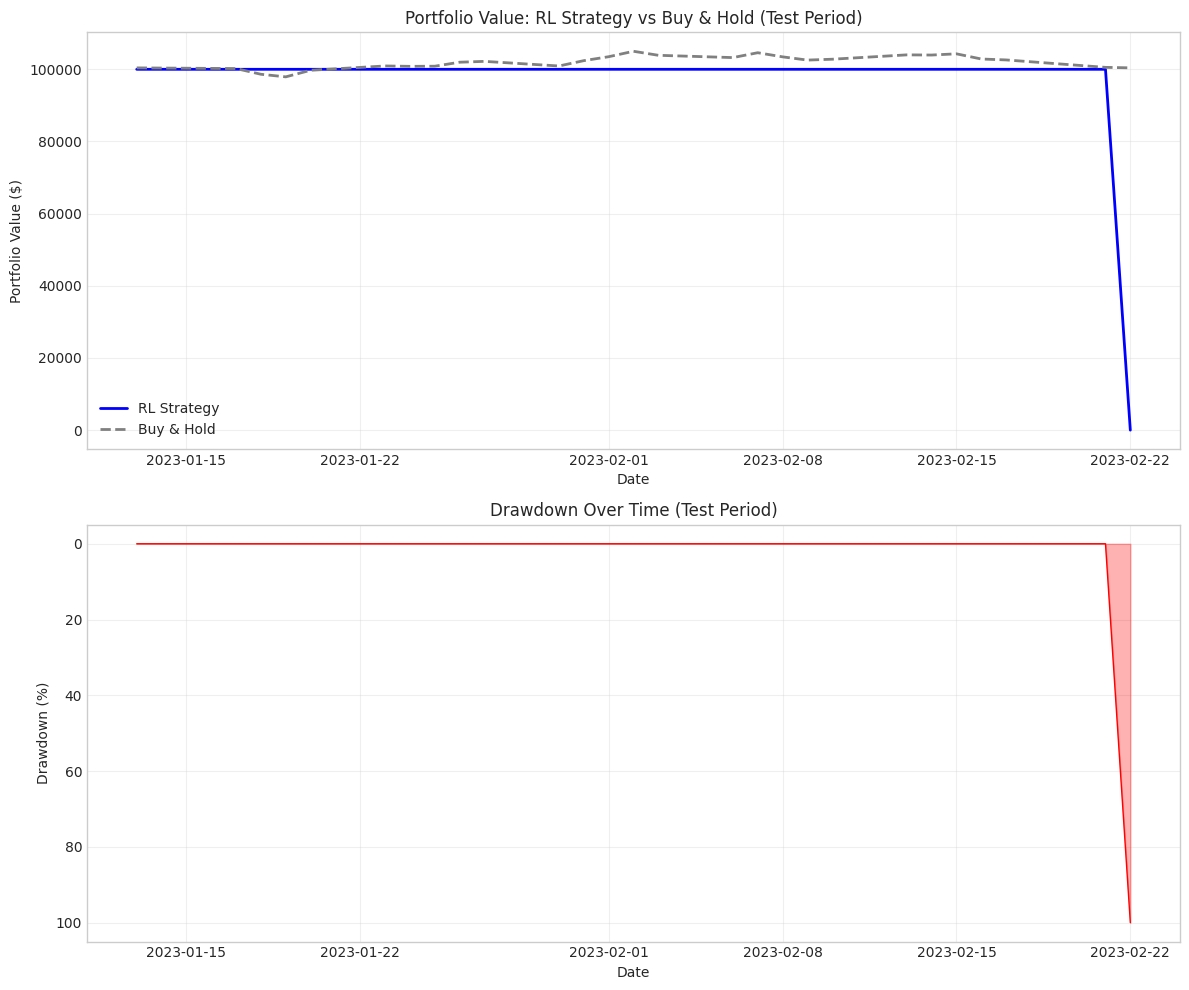

In [13]:
# Get portfolio history from test evaluation
portfolio_history = test_metrics.get('portfolio_history')

if portfolio_history is not None and len(portfolio_history) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Portfolio value vs Buy & Hold
    ax = axes[0]
    
    # Strategy portfolio
    ax.plot(portfolio_history.index, portfolio_history['portfolio_value'], 
            label='RL Strategy', linewidth=2, color='blue')
    
    # Buy & Hold portfolio
    initial_value = 100000
    bh_values = initial_value * (test_df['price_Close'] / test_df['price_Close'].iloc[0])
    # Align dates
    common_dates = portfolio_history.index.intersection(bh_values.index)
    if len(common_dates) > 0:
        ax.plot(common_dates, bh_values.loc[common_dates], 
                label='Buy & Hold', linewidth=2, color='gray', linestyle='--')
    
    ax.set_title('Portfolio Value: RL Strategy vs Buy & Hold (Test Period)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Drawdown
    ax = axes[1]
    portfolio_values = portfolio_history['portfolio_value'].values
    cummax = np.maximum.accumulate(portfolio_values)
    drawdown = (cummax - portfolio_values) / cummax * 100
    
    ax.fill_between(portfolio_history.index, 0, drawdown, color='red', alpha=0.3)
    ax.plot(portfolio_history.index, drawdown, color='red', linewidth=1)
    ax.set_title('Drawdown Over Time (Test Period)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Drawdown (%)')
    ax.invert_yaxis()  # Drawdown is typically shown inverted
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No portfolio history available for plotting")

## 6. Walk-Forward Validation

Walk-forward validation is critical for time-series models. It simulates realistic model retraining.

In [14]:
from rl.walk_forward import WalkForwardValidator

print("Setting up Walk-Forward Validation...")
print("(This trains multiple models on different time windows)")

validator = WalkForwardValidator(
    df=df_clean,
    feature_columns=feature_columns,
    regime_column='regime_numeric',
    n_regimes=3,
    price_column='price_Close',
    n_windows=3,  # 3 validation windows
    train_pct=0.7,
    min_train_days=200,
    min_test_days=50,
    verbose=1
)

print(f"\nGenerated {len(validator.windows)} walk-forward windows:")
for w in validator.windows:
    print(f"  Window {w.window_id + 1}: Train {w.train_start.date()} to {w.train_end.date()}, "
          f"Test {w.test_start.date()} to {w.test_end.date()}")

Setting up Walk-Forward Validation...
(This trains multiple models on different time windows)

Generated 2 walk-forward windows:
  Window 1: Train 2020-10-15 to 2021-11-26, Test 2021-11-29 to 2022-05-20
  Window 2: Train 2021-11-09 to 2022-12-21, Test 2022-12-22 to 2023-06-16


In [15]:
# Run walk-forward validation
# Note: Using reduced timesteps for notebook demo
print("\n" + "="*60)
print("RUNNING WALK-FORWARD VALIDATION")
print("="*60)

wf_results = validator.run(
    total_timesteps=25000,  # Reduced for demo
    seeds=[42],  # Single seed for speed
    save_models=False
)


RUNNING WALK-FORWARD VALIDATION

Window 1/2
Train: 2020-10-15 to 2021-11-26 (282 days)
Test:  2021-11-29 to 2022-05-20 (121 days)


Output()

Output()

  Seed 42: Train Return=-100.8%, Test Return=-100.2%

Window 2/2
Train: 2021-11-09 to 2022-12-21 (282 days)
Test:  2022-12-22 to 2023-06-16 (121 days)


  Seed 42: Train Return=-1006.2%, Test Return=-101.6%


In [16]:
# Print walk-forward summary
validator.print_summary(wf_results)


WALK-FORWARD VALIDATION SUMMARY

Windows: 2, Seeds per window: 1

Metric                         Strategy        Buy & Hold     
------------------------------------------------------------
Mean Return                    -100.86%         -0.35%
Std Return                     0.69%          15.78%
Mean Sharpe                    11.379
Mean Max Drawdown              100.86%
Win Rate (windows > 0)         0.0%

Overfitting Check             
  Train Mean Return            -553.51%
  Test Mean Return             -100.86%
  Overfit Ratio                5.49x



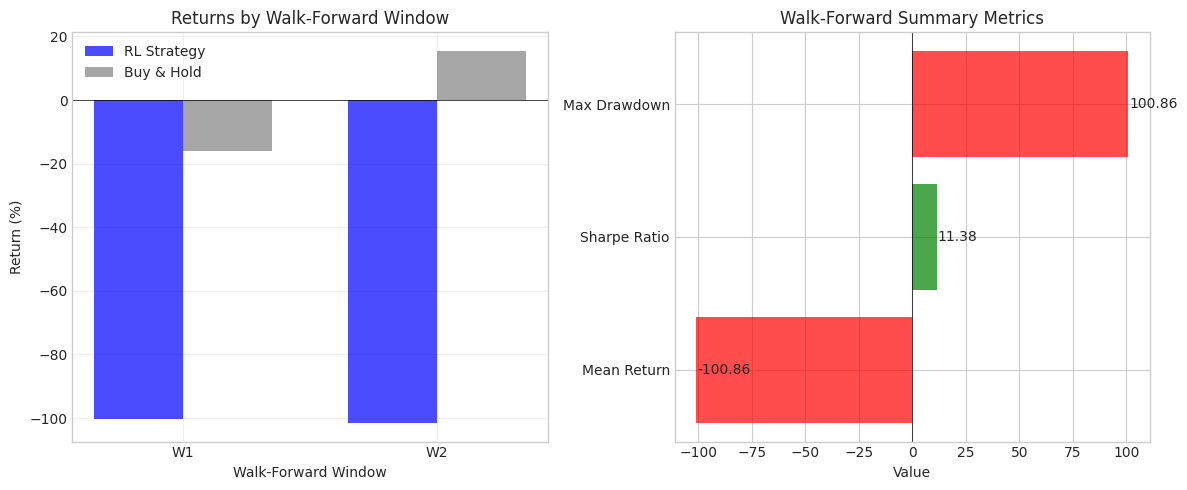

In [17]:
# Visualize walk-forward results
summary = wf_results['summary']
baseline = wf_results['baseline']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Returns by window
ax = axes[0]
windows = range(1, len(summary['per_window_returns']) + 1)
width = 0.35

strategy_returns = [r * 100 for r in summary['per_window_returns']]
baseline_returns = [r * 100 for r in baseline['per_window_returns']]

x = np.arange(len(windows))
bars1 = ax.bar(x - width/2, strategy_returns, width, label='RL Strategy', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, baseline_returns, width, label='Buy & Hold', color='gray', alpha=0.7)

ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('Walk-Forward Window')
ax.set_ylabel('Return (%)')
ax.set_title('Returns by Walk-Forward Window')
ax.set_xticks(x)
ax.set_xticklabels([f'W{i}' for i in windows])
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Summary metrics
ax = axes[1]
metrics = ['Mean Return', 'Sharpe Ratio', 'Max Drawdown']
strategy_vals = [
    summary['test_mean_return'] * 100,
    summary['test_mean_sharpe'],
    summary['test_mean_drawdown'] * 100
]

colors = ['green' if v > 0 else 'red' for v in strategy_vals]
colors[2] = 'red'  # Drawdown is always "bad"

bars = ax.barh(metrics, strategy_vals, color=colors, alpha=0.7)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Value')
ax.set_title('Walk-Forward Summary Metrics')

# Add value labels
for bar, val in zip(bars, strategy_vals):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}', va='center')

plt.tight_layout()
plt.show()

## 7. Regime-Conditional Analysis

Does the agent perform differently in different regimes?

In [18]:
# Analyze agent behavior by regime
# Re-run evaluation to get detailed action history

eval_env = TradingEnv(
    df=test_df,
    feature_columns=feature_columns,
    price_column='price_Close',
    regime_column='regime_numeric',
    n_regimes=3,
    initial_balance=100000.0,
    transaction_cost=0.001
)

obs, info = eval_env.reset()
actions_by_regime = {'Expansion': [], 'Contraction': [], 'Crisis': []}
regime_names = {0: 'Expansion', 1: 'Contraction', 2: 'Crisis'}

done = False
step = 0
while not done:
    action, _ = trader.predict(obs, deterministic=True)
    
    # Get current regime
    current_regime = test_df.iloc[eval_env.current_step]['regime_numeric']
    regime_name = regime_names.get(current_regime, 'Unknown')
    
    if regime_name in actions_by_regime:
        actions_by_regime[regime_name].append(action)
    
    obs, reward, terminated, truncated, info = eval_env.step(action)
    done = terminated or truncated
    step += 1

# Analyze action distribution by regime
print("\nAgent Action Distribution by Regime:")
print("="*50)
action_names = {0: 'Sell', 1: 'Hold', 2: 'Buy'}

for regime, actions in actions_by_regime.items():
    if len(actions) > 0:
        action_counts = pd.Series(actions).value_counts(normalize=True)
        print(f"\n{regime} ({len(actions)} steps):")
        for action_id in [0, 1, 2]:
            pct = action_counts.get(action_id, 0) * 100
            print(f"  {action_names[action_id]}: {pct:.1f}%")


Agent Action Distribution by Regime:

Contraction (27 steps):
  Sell: 92.6%
  Hold: 7.4%
  Buy: 0.0%


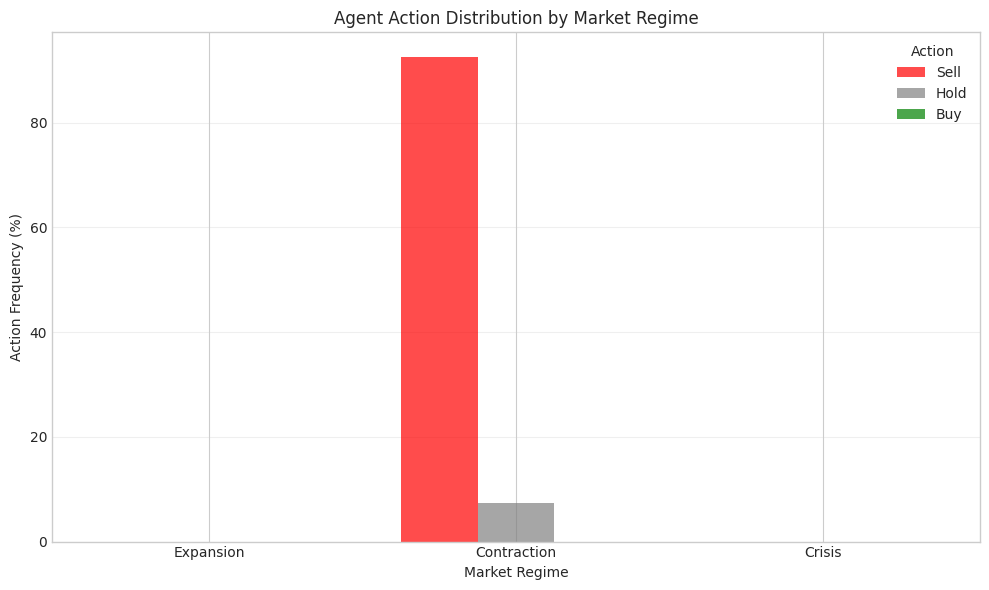

In [19]:
# Visualize action distribution by regime
fig, ax = plt.subplots(figsize=(10, 6))

regime_order = ['Expansion', 'Contraction', 'Crisis']
action_order = ['Sell', 'Hold', 'Buy']
colors = ['red', 'gray', 'green']

# Build data for stacked bar chart
data = {}
for regime in regime_order:
    actions = actions_by_regime.get(regime, [])
    if len(actions) > 0:
        counts = pd.Series(actions).value_counts(normalize=True)
        data[regime] = [counts.get(i, 0) * 100 for i in range(3)]
    else:
        data[regime] = [0, 0, 0]

x = np.arange(len(regime_order))
width = 0.25

for i, (action_name, color) in enumerate(zip(action_order, colors)):
    values = [data[regime][i] for regime in regime_order]
    ax.bar(x + i*width, values, width, label=action_name, color=color, alpha=0.7)

ax.set_xlabel('Market Regime')
ax.set_ylabel('Action Frequency (%)')
ax.set_title('Agent Action Distribution by Market Regime')
ax.set_xticks(x + width)
ax.set_xticklabels(regime_order)
ax.legend(title='Action')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Key Findings Summary

In [20]:
print("="*70)
print("MILESTONE 4: RL TRADING AGENT - KEY FINDINGS")
print("="*70)

print(f"\n1. ENVIRONMENT:")
print(f"   State dimension: {env.observation_space.shape[0]} features")
print(f"   Action space: 3 discrete actions (Sell, Hold, Buy)")
print(f"   Reward: Differential Sharpe ratio with drawdown penalty")

print(f"\n2. SINGLE TRAIN/TEST SPLIT:")
print(f"   Train Return: {train_metrics['total_return']*100:+.2f}%")
print(f"   Test Return:  {test_metrics['total_return']*100:+.2f}%")
print(f"   Buy & Hold:   {test_bh_return*100:+.2f}%")

print(f"\n3. WALK-FORWARD VALIDATION ({len(validator.windows)} windows):")
print(f"   Mean Test Return: {summary['test_mean_return']*100:+.2f}% (+/- {summary['test_std_return']*100:.2f}%)")
print(f"   Mean Sharpe Ratio: {summary['test_mean_sharpe']:.3f}")
print(f"   Win Rate (windows > 0): {summary['test_win_rate']*100:.1f}%")

if summary['p_value'] is not None:
    print(f"   Statistical Significance: p={summary['p_value']:.4f}")

print(f"\n4. REGIME-CONDITIONAL BEHAVIOR:")
for regime, actions in actions_by_regime.items():
    if len(actions) > 0:
        buy_pct = sum(1 for a in actions if a == 2) / len(actions) * 100
        sell_pct = sum(1 for a in actions if a == 0) / len(actions) * 100
        print(f"   {regime}: Buy={buy_pct:.1f}%, Sell={sell_pct:.1f}%")

print("\n" + "="*70)

MILESTONE 4: RL TRADING AGENT - KEY FINDINGS

1. ENVIRONMENT:
   State dimension: 16 features
   Action space: 3 discrete actions (Sell, Hold, Buy)
   Reward: Differential Sharpe ratio with drawdown penalty

2. SINGLE TRAIN/TEST SPLIT:
   Train Return: -100.30%
   Test Return:  -100.01%
   Buy & Hold:   +19.74%

3. WALK-FORWARD VALIDATION (2 windows):
   Mean Test Return: -100.86% (+/- 0.69%)
   Mean Sharpe Ratio: 11.379
   Win Rate (windows > 0): 0.0%

4. REGIME-CONDITIONAL BEHAVIOR:
   Contraction: Buy=0.0%, Sell=7.4%



In [21]:
print("\nNotebook complete!")
print("\nNext steps:")
print("  - Milestone 5: Ablation studies (price-only vs +regime vs +sentiment)")
print("  - Statistical significance testing across configurations")
print("  - Final documentation and results summary")


Notebook complete!

Next steps:
  - Milestone 5: Ablation studies (price-only vs +regime vs +sentiment)
  - Statistical significance testing across configurations
  - Final documentation and results summary
